In [42]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az
import seaborn as sns
from numpyro.diagnostics import hpdi
import pandas as pd
import numpy as np

<h1> Generate Data </h1>

$$y_i \sim \beta_i + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma^2)$$
We generate $N$ data realizations with 400 observations per realization. Our true parameter vector $\beta^*$ has $20$ non-zero entries with values $1, 2, ..., 10$.

In [53]:
# Parameters
n_realizations = 2
p = 400  # Total number of predictors
p_star = 20 # Total number of non-zero predictors
sigma = 1 # Noise parameter

# Generate data
def get_data(A):
    y_realizations = []
    beta_stars = []
    for _ in range(n_realizations):
        # Create true beta vector beta_star
        beta_star = np.zeros(p)
        beta_star[range(20)] = A

        # Generate response variable y
        y = beta_star + np.random.randn(p) * sigma

        # Store the generated data
        y_realizations.append(y)
        beta_stars.append(beta_star)

    # Convert lists to numpy arrays 
    y_realizations = np.array(y_realizations)
    beta_stars = np.array(beta_stars)
    return y_realizations, beta_stars

all_data = {}
A_values = [4, 6]
for A in A_values:
    all_data[A] = get_data(A)

<h2> Define the Model </h2>

Horseshoe prior:
$$ y_i \sim N(\beta_i, \sigma^2) \quad \text{for } i = 1,2,\ldots,n$$ 
$$ \beta_i \sim N(0, \tau^2 \lambda_i^2) $$
$$ \tau \sim C^+(0, 1)$$
$$ \lambda_i \sim C^+(0, 1)$$



where $\beta$ is the average of all $\beta_i$ and $\sigma = 0.1$ in this example.

In [54]:
def horseshoe_linear_model(y=None, sigma=1):
    '''
    Parameters:
       array y: dependent variable
       int sigma: stdev of y
    '''
    n_predictors = y.shape[0]
    tau = numpyro.sample('tau', dist.HalfCauchy(1))
    lambdas = numpyro.sample("lambdas", dist.HalfCauchy(jnp.ones(n_predictors)))

    unscaled_betas = numpyro.sample("unscaled_betas", dist.Normal(0, 1).expand([n_predictors]))
    scaled_betas = numpyro.deterministic("betas", tau*lambdas*unscaled_betas)

    numpyro.sample('y', dist.Normal(scaled_betas, sigma), obs=y)

<h1> Run and Evaluate MCMC </h1>

In [55]:
def run_mcmc(y):
    horseshoe_mcmc = MCMC(
        NUTS(horseshoe_linear_model),
        num_warmup=500,
        num_samples=1000,
        num_chains = 4
    )
    horseshoe_mcmc.run(random.PRNGKey(0), y=y)
    return horseshoe_mcmc

all_samples = {}
for A, (y_realizations, beta_stars) in all_data.items():
    samples = []
    for y in y_realizations:
        mcmc = run_mcmc(y)
        samples.append(mcmc.get_samples())
    all_samples[A] = samples

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_21678/159601173.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  horseshoe_mcmc = MCMC(
sample: 100%|██████████| 1500/1500 [00:01<00:00, 982.49it/s, 63 steps of size 5.07e-02. acc. prob=0.81]  
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_21678/159601173.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  horseshoe_mcmc = MCMC(
sa

The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [48]:
for mcmc in mcmc_results_A4:
    print(az.ess(mcmc))
    print(az.rhat(mcmc))

<xarray.Dataset> Size: 19kB
Dimensions:               (betas_dim_0: 400, lambdas_dim_0: 400,
                           unscaled_betas_dim_0: 400)
Coordinates:
  * betas_dim_0           (betas_dim_0) int64 3kB 0 1 2 3 4 ... 396 397 398 399
  * lambdas_dim_0         (lambdas_dim_0) int64 3kB 0 1 2 3 ... 396 397 398 399
  * unscaled_betas_dim_0  (unscaled_betas_dim_0) int64 3kB 0 1 2 ... 397 398 399
Data variables:
    betas                 (betas_dim_0) float64 3kB 2.21e+03 564.8 ... 2.328e+03
    lambdas               (lambdas_dim_0) float64 3kB 1.5e+03 ... 2.294e+03
    tau                   float64 8B 97.62
    unscaled_betas        (unscaled_betas_dim_0) float64 3kB 2.461e+03 ... 2....
<xarray.Dataset> Size: 19kB
Dimensions:               (betas_dim_0: 400, lambdas_dim_0: 400,
                           unscaled_betas_dim_0: 400)
Coordinates:
  * betas_dim_0           (betas_dim_0) int64 3kB 0 1 2 3 4 ... 396 397 398 399
  * lambdas_dim_0         (lambdas_dim_0) int64 3kB 0 1 2 3 ..

<h1> Results </h1>

2


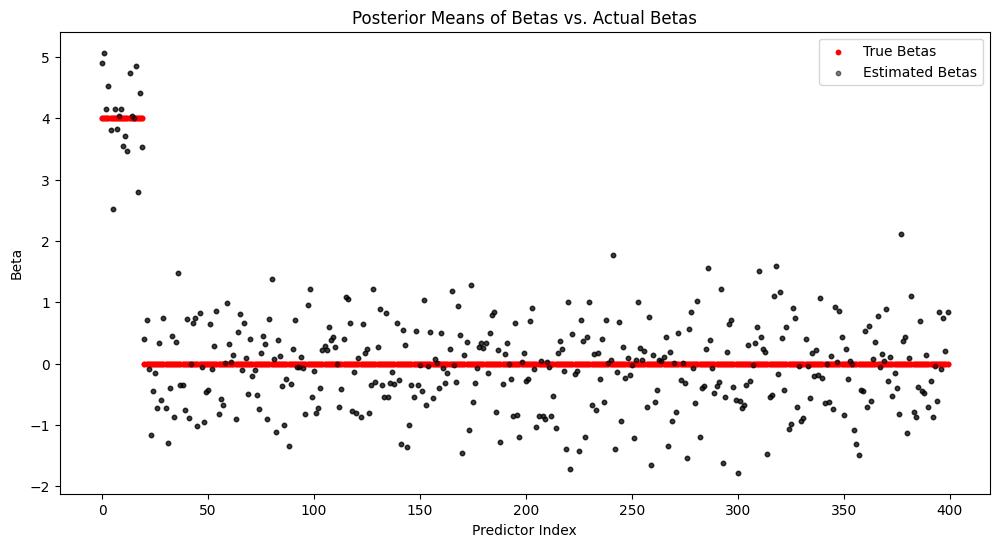

2


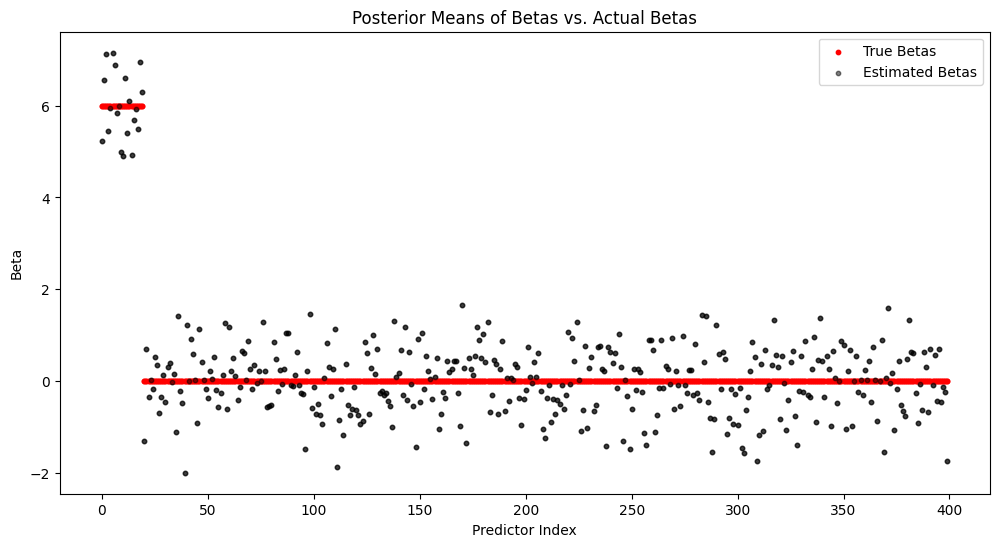

In [64]:
def plot_posterior_betas(A, beta_stars, posterior_samples):
    print(len(beta_stars))
    plt.figure(figsize=(12, 6))
    for i in range(len(beta_stars)):
        estimated_betas = posterior_samples.mean(axis=0)
        plt.scatter(range(len(beta_stars[i])), beta_stars[i], color='red', s=10, label='True Betas' if i == 0 else "")
        plt.scatter(range(len(estimated_betas)), estimated_betas, color='black', s=10, alpha=0.5, label='Estimated Betas' if i == 0 else "")

    plt.title(f'Posterior Means of Betas vs. Actual Betas')
    plt.xlabel('Predictor Index')
    plt.ylabel('Beta')
    plt.legend()
    plt.show()

for A in A_values:
    plot_posterior_betas(A, all_data[A][1], all_data[A][0])
